## Реализация алгоритма кластеризации K-Means

### Импорт библиотек

In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_mutual_info_score

### Реализация класса CustomKMeans

In [2]:
from pandas.core.arrays import boolean
def log_plot(X: np.ndarray, labels: np.ndarray, centroids: np.ndarray, i: int):
    plt.figure(figsize=(6,6))
    for cl in range(len(centroids)):
        plt.scatter(X[labels == cl, 0], X[labels == cl, 1], s=50, label='Cluster_'+str(cl+1))
    plt.scatter(centroids[:, 0], centroids[:,1], s=150, c='Black', label='Centroids', marker='x')
    plt.title("Положение центроидов на {} итерации".format(i+1))
    plt.legend()

class CustomKMeans:
    def __init__(self, n_clusters: int = 3, max_iter: int = 300, random_state: int = 42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
    
    # Обучение
    def fit(self, X: np.ndarray, log: bool = False):
        self.centroids = self.__init_centroids(X) # Начальная инициализация центроидов
        if log:
            print("Начальное положение центроидов:\n{}\n".format(self.centroids)) # log
        for i in range(self.max_iter):
            old_centroids = self.centroids 
            distance = self.__compute_distance(X, old_centroids)      # Подсчет расстояний
            self.labels = self.__find_closest_cluster(distance)       # Поиск ближайших кластеров
            self.centroids = self.__compute_centroids(X, self.labels) # Обновление центроидов
            if log:
                print("Положение центроидов на {} итерации:\n{}\n".format(i+1, self.centroids))
                log_plot(X, self.labels, self.centroids, i)
            if np.all(old_centroids == self.centroids):               # Условие останова - старые центроиды равны новым
                break
        self.error = self.__compute_sse(X, self.labels, self.centroids) # Подсчет SSE
        return self

    # Предсказание
    def predict(self, X: np.ndarray) -> np.ndarray:
        distance = self.__compute_distance(X, self.centroids) # Подсчет расстояний
        return self.__find_closest_cluster(distance)          # Поиск ближайших кластеров

    # Начальная инициализация центроидов
    def __init_centroids(self, X: np.ndarray) -> np.ndarray:
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        return X[random_idx[:self.n_clusters]]

    # Вычисление центроидов
    def __compute_centroids(self, X: np.ndarray, labels: np.ndarray) -> np.ndarray:
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids
    
    # Вычисление расстояния до центроидов
    def __compute_distance(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = la.norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance
    
    # Вычисление ближайшего кластера
    def __find_closest_cluster(self, distance: np.ndarray) -> np.ndarray:
        return np.argmin(distance, axis=1)

    # Вычисление ошибки SSE
    def __compute_sse(self, X: np.ndarray, labels: np.ndarray, centroids: np.ndarray) -> float:
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = la.norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))


### Пример использования реализованного класса

In [3]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

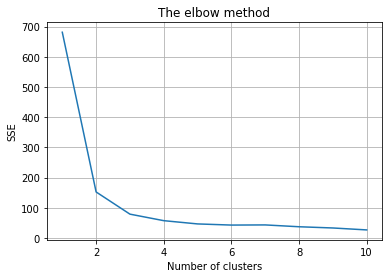

In [5]:
# Метод локтя
sse = []

for i in range(1, 11):
    model = CustomKMeans(n_clusters=i)
    model.fit(X)
    sse.append(model.error)

plt.plot(range(1, 11), sse)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid()
plt.show()

Видим, что оптимальным количеством кластеров будет 3

In [6]:
model = CustomKMeans(n_clusters=3)

Тренируем модель и смотрим на изменение положения центроидов и принадлежность элементов к кластерам

Начальное положение центроидов:
[[6.4 2.7 5.3 1.9]
 [5.2 3.4 1.4 0.2]
 [5.6 3.  4.1 1.3]]

Положение центроидов на 1 итерации:
[[6.57674419 3.01627907 5.37209302 1.94651163]
 [4.97407407 3.44074074 1.44444444 0.25185185]
 [5.72666667 2.71333333 4.08333333 1.26      ]]

Положение центроидов на 2 итерации:
[[6.59047619 3.03571429 5.38095238 1.95714286]
 [4.97407407 3.44074074 1.44444444 0.25185185]
 [5.73548387 2.69677419 4.11290323 1.26774194]]

Положение центроидов на 3 итерации:
[[6.615      3.045      5.4125     1.9725    ]
 [4.97407407 3.44074074 1.44444444 0.25185185]
 [5.75757576 2.70606061 4.15151515 1.29090909]]

Положение центроидов на 4 итерации:
[[6.61794872 3.05128205 5.43333333 1.98461538]
 [4.97407407 3.44074074 1.44444444 0.25185185]
 [5.77941176 2.70882353 4.16470588 1.29705882]]

Положение центроидов на 5 итерации:
[[6.66388889 3.06388889 5.48333333 2.00833333]
 [4.97407407 3.44074074 1.44444444 0.25185185]
 [5.8027027  2.72432432 4.21891892 1.32972973]]

Положение цент

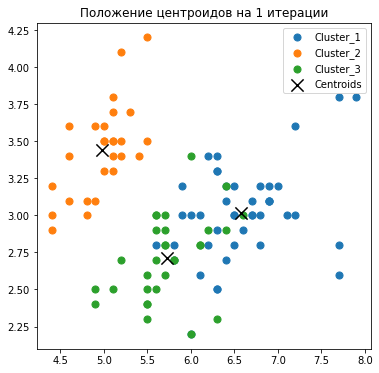

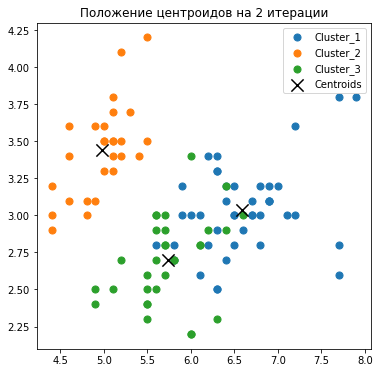

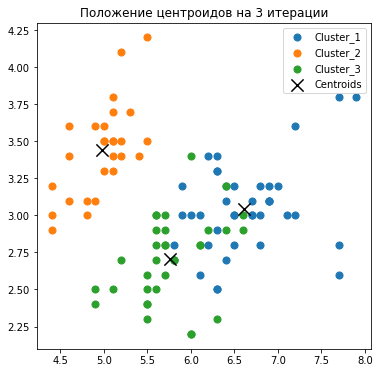

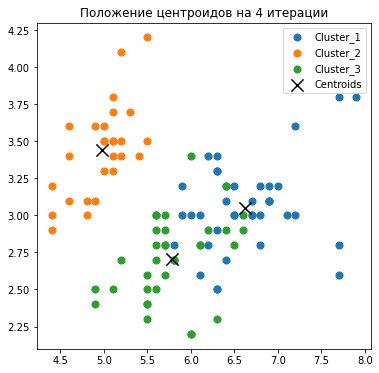

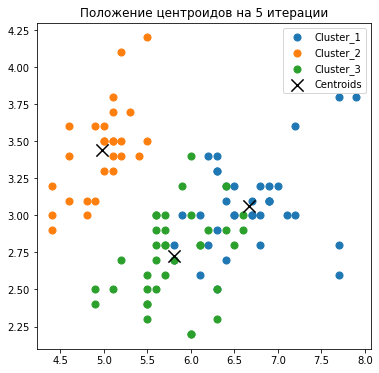

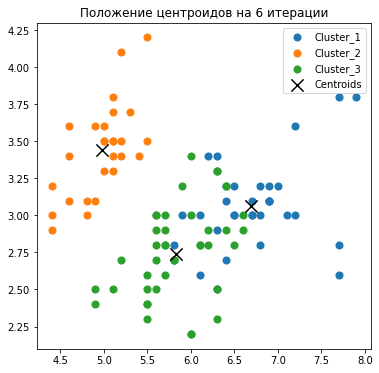

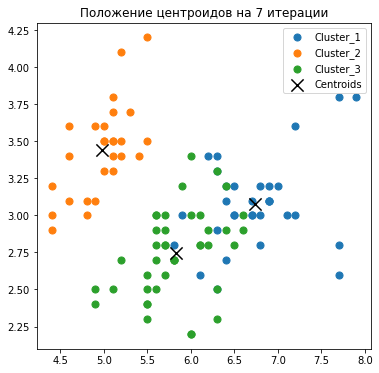

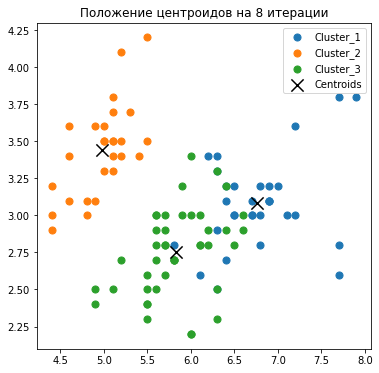

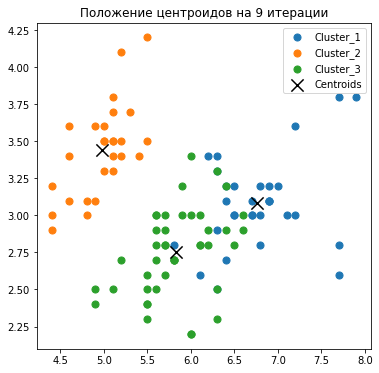

In [7]:
model.fit(X_train, log=True)

In [8]:
y_pred = model.predict(X_test)

Визуализируем получившиеся результаты кластеризации на тестовой выборке

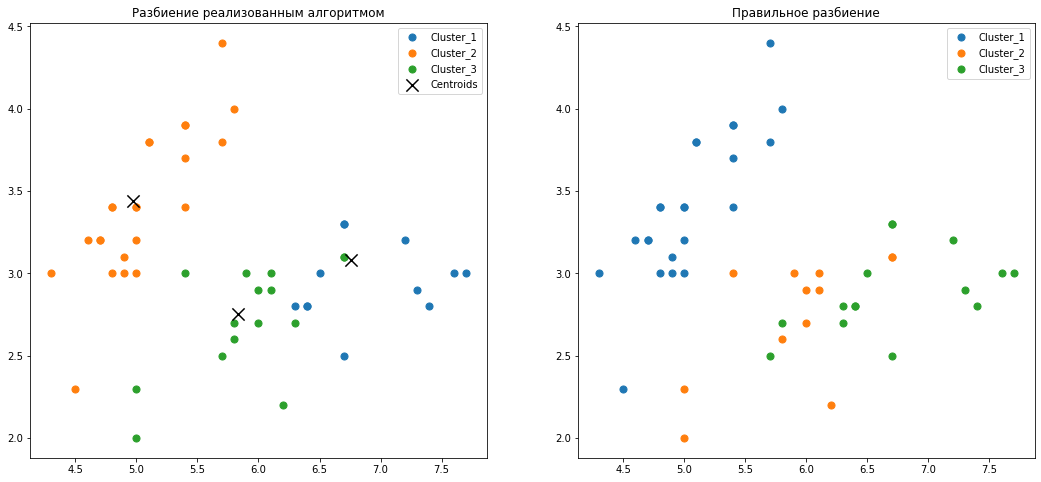

In [9]:
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.scatter(X_test[y_pred == 0, 0], X_test[y_pred == 0, 1], s=50, label='Cluster_1')
plt.scatter(X_test[y_pred == 1, 0], X_test[y_pred == 1, 1], s=50, label='Cluster_2')
plt.scatter(X_test[y_pred == 2, 0], X_test[y_pred == 2, 1], s=50, label='Cluster_3')
plt.scatter(model.centroids[:, 0], model.centroids[:,1], s=150, c='Black', label='Centroids', marker='x')
plt.title("Разбиение реализованным алгоритмом")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], s=50, label='Cluster_1')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], s=50, label='Cluster_2')
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1], s=50, label='Cluster_3')
plt.title("Правильное разбиение")

plt.legend()
plt.show()

Вычислим SSE и AMI

In [10]:
model.error

52.795366103430624

In [11]:
adjusted_mutual_info_score(y_test, y_pred)

0.852490501452646

## Сравним результат с библиотечным методом из sklearn

In [12]:
from sklearn.cluster import KMeans

In [13]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=1, random_state=4)
kmeans.fit(X_train)

KMeans(n_clusters=3, n_init=1, random_state=4)

In [14]:
kmeans_pred = model.predict(X_test)

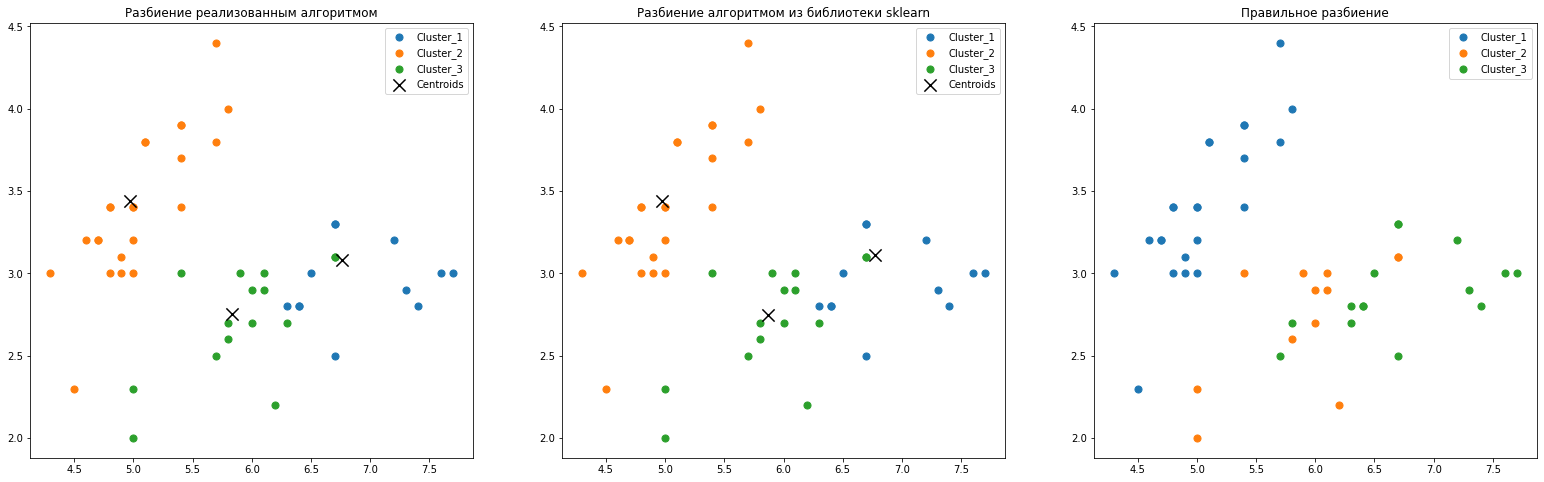

In [15]:
plt.figure(figsize=(27,8))

plt.subplot(1, 3, 1)
plt.scatter(X_test[y_pred == 0, 0], X_test[y_pred == 0, 1], s=50, label='Cluster_1')
plt.scatter(X_test[y_pred == 1, 0], X_test[y_pred == 1, 1], s=50, label='Cluster_2')
plt.scatter(X_test[y_pred == 2, 0], X_test[y_pred == 2, 1], s=50, label='Cluster_3')
plt.scatter(model.centroids[:, 0], model.centroids[:,1], s=150, c='Black', label='Centroids', marker='x')
plt.title("Разбиение реализованным алгоритмом")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_test[kmeans_pred == 0, 0], X_test[kmeans_pred == 0, 1], s=50, label='Cluster_1')
plt.scatter(X_test[kmeans_pred == 1, 0], X_test[kmeans_pred == 1, 1], s=50, label='Cluster_2')
plt.scatter(X_test[kmeans_pred == 2, 0], X_test[kmeans_pred == 2, 1], s=50, label='Cluster_3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s=150, c='Black', label='Centroids', marker='x')
plt.title("Разбиение алгоритмом из библиотеки sklearn")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], s=50, label='Cluster_1')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], s=50, label='Cluster_2')
plt.scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1], s=50, label='Cluster_3')
plt.title("Правильное разбиение")
plt.legend()

plt.show()

In [16]:
kmeans.inertia_

52.81594653430861

In [17]:
adjusted_mutual_info_score(y_test, kmeans_pred)

0.852490501452646

## Вывод

Таким образом, в ходе выполнения данной работы был самостоятельно реализован алгоритм K-Means на языке Python. Было проведено его тестирование на классическом наборе данных, а также сравнение реализованного алгоритма с готовым библиотечным методом. В ходе экспериментов было выявлено, что метод успешно справляется с задачей кластеризации.